In [2]:
import os
# import psignifit as ps
import glob
# import pickle as pkl
#import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Import this before pandas
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl

In [3]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils

ImportError: No module named analyze2p.plotting

In [3]:
#set_plot_params()
visual_areas, area_colors = pplot.set_threecolor_palette() 

In [4]:
%matplotlib notebook

In [5]:
# Main src
# aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
# rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data'
traceid = 'traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
trial_epoch = 'plushalf'
overlap_thr=None
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap-%.2f' % overlap_thr

fov_type = 'zoom2p0x'

In [6]:
# SOURCE: neuraldata
src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')
fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
        % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)
src_datafile = os.path.join(src_data_dir, '%s.pkl' % fname)
print(src_datafile)
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]
print(data_id)
# Load -----------------------------
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# print(D.keys())
# DATA = D['DATA']
# sdata = D['sdata']
# SDF = D['SDF']
# # selective_df = D['selective_df']

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF.pkl
neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF


In [7]:
# SOURCE: NDATA
import analyze2p.aggregate_datasets as aggr
# SET PATHS
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'
migr_prefix = '/n/holylfs05/LABS/pfister_lab/Lab/coxfs01'
aggregate_dir = aggregate_dir.replace('/n/coxfs01', migr_prefix)
rootdir = rootdir.replace('/n/coxfs01', migr_prefix)
# --
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                create_new=False,
                                return_cells=True, return_missing=True,
                                rootdir=rootdir,
                                aggregate_dir=aggregate_dir)

# Get ROIs from assigned visual areas
experiment='blobs'
trial_epoch = 'stimulus' #'stimulus'
responsive_test='ROC' #'ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'
assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)
## Check stimuli
SDF, incorrect_stims = aggr.check_sdfs(NDATA0['datakey'].unique(), #n_cells_all['datakey'].unique(),
                      experiment='blobs', rename=True, images_only=False,
                      return_incorrect=True, return_all=False)
print(incorrect_stims.keys())

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
dict_keys(['20190314_JC070_fov1', '20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1', '20190327_JC073_fov1'])


# Traces

In [8]:
import analyze2p.extraction.traces as traceutils

In [9]:
va = 'V1'
dk = '20190507_JC083_fov1'
# -----------------
ndata_ = NDATA0[(NDATA0['datakey']==dk) & (NDATA0['visual_area']==va)].copy()
ndata_['response'].min()

-0.8256067684339292

In [10]:
check_rois= []
for cell, d in ndata_.groupby('cell'):
    if d.groupby('config').mean()['response'].min() < 0\
    and d.groupby('config').mean()['response'].max() < 0.3:
        break
        check_rois.append(cell)

In [11]:
d.groupby('config').mean()['response'].min()

-0.004041694004778828

In [12]:
d.groupby('config').mean()['response'].max()

0.061494079603018365

In [13]:
cell

3

In [14]:
import analyze2p.extraction.traces as traceutils

In [15]:
dk = '20190507_JC083_fov1'
# ------------------
data_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs',
                                       rootdir=rootdir)
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected',
                                                    rootdir=rootdir)
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

# configs
sdf = SDF[SDF['datakey']==dk].copy()
sdf['morph-size'] = ['{}_{}'.format(m, s) for m, s \
                         in sdf[['morphlevel', 'size']].values]
sdf['config'] = sdf.index.tolist()
cfgs_ = sdf.index.tolist() #sdf[sdf['size']==30].index.tolist()

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/2p-data/JC083/20190507/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_8afe5f_traces001_7ab5af_traces001_488b31_traces001_c8dfc7_traces001_df5b92_traces001_431894/data_arrays/corrected.npz
--- processed traces: dff


In [16]:
rid = 3
tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf, #sdf[sdf.morphlevel.isin(morphlevels)], 
                    param='config', 
                    return_stacked=True, smooth=True, win_size=9)

tdf['morph-size'] = ['{}_{}'.format(sdf.loc[c]['morphlevel'], sdf.loc[c]['size']) \
                     for c in tdf['config'].values]
tdf['morphlevel'] = [m.split('_')[0] for m in tdf['morph-size']]
tdf['size'] = [m.split('_')[1] for m in tdf['morph-size']]

[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


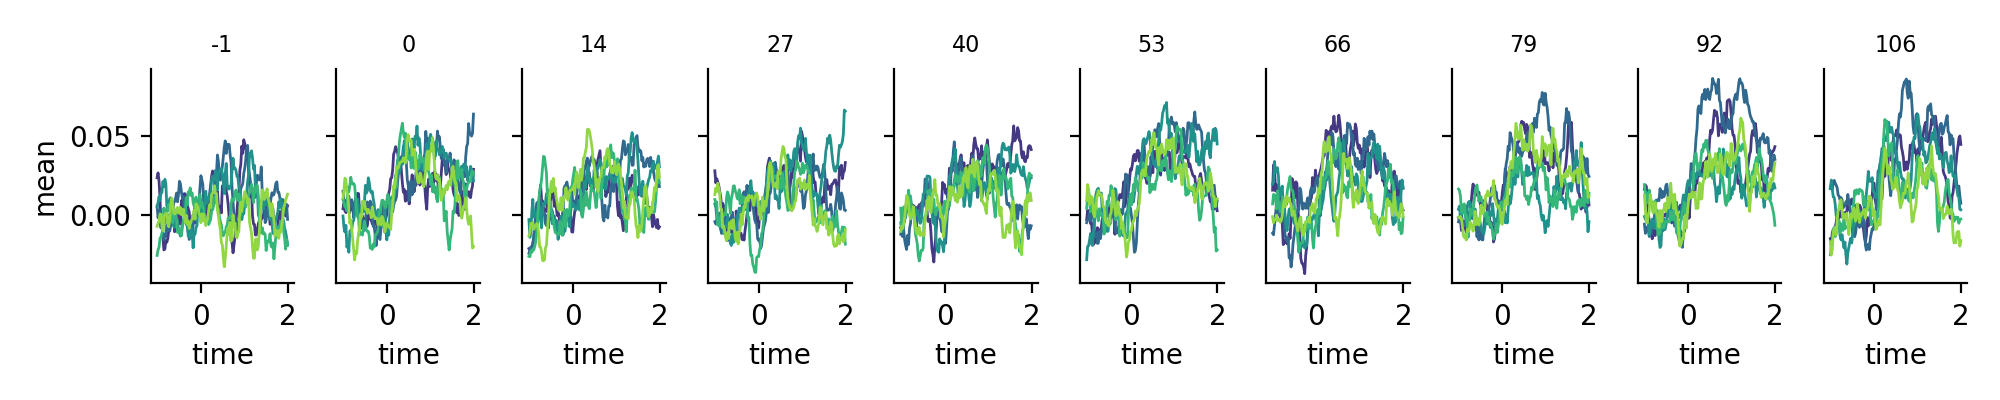

In [17]:
# PLOT
sizes = sorted(sdf['size'].unique())
print(sizes)
hue_var = 'morphlevel'
fg = sns.FacetGrid(data=tdf, col='morphlevel', #col_order=morphlevels, 
                   #row='size', row_order=sizes, 
                   height=2, aspect=0.5, hue='size', #hue_order=sizes,
                   palette='viridis')
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.set_titles('{col_name}', size=8)

In [18]:
import analyze2p.objects.selectivity as sel


In [19]:
offset_type='minsub' 
lcorrection='exclude'

# x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
#           & (NDATA0.config.isin(configs))].copy()
x0 = ndata_.copy()
rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
         .mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values

<IPython.core.display.Javascript object>


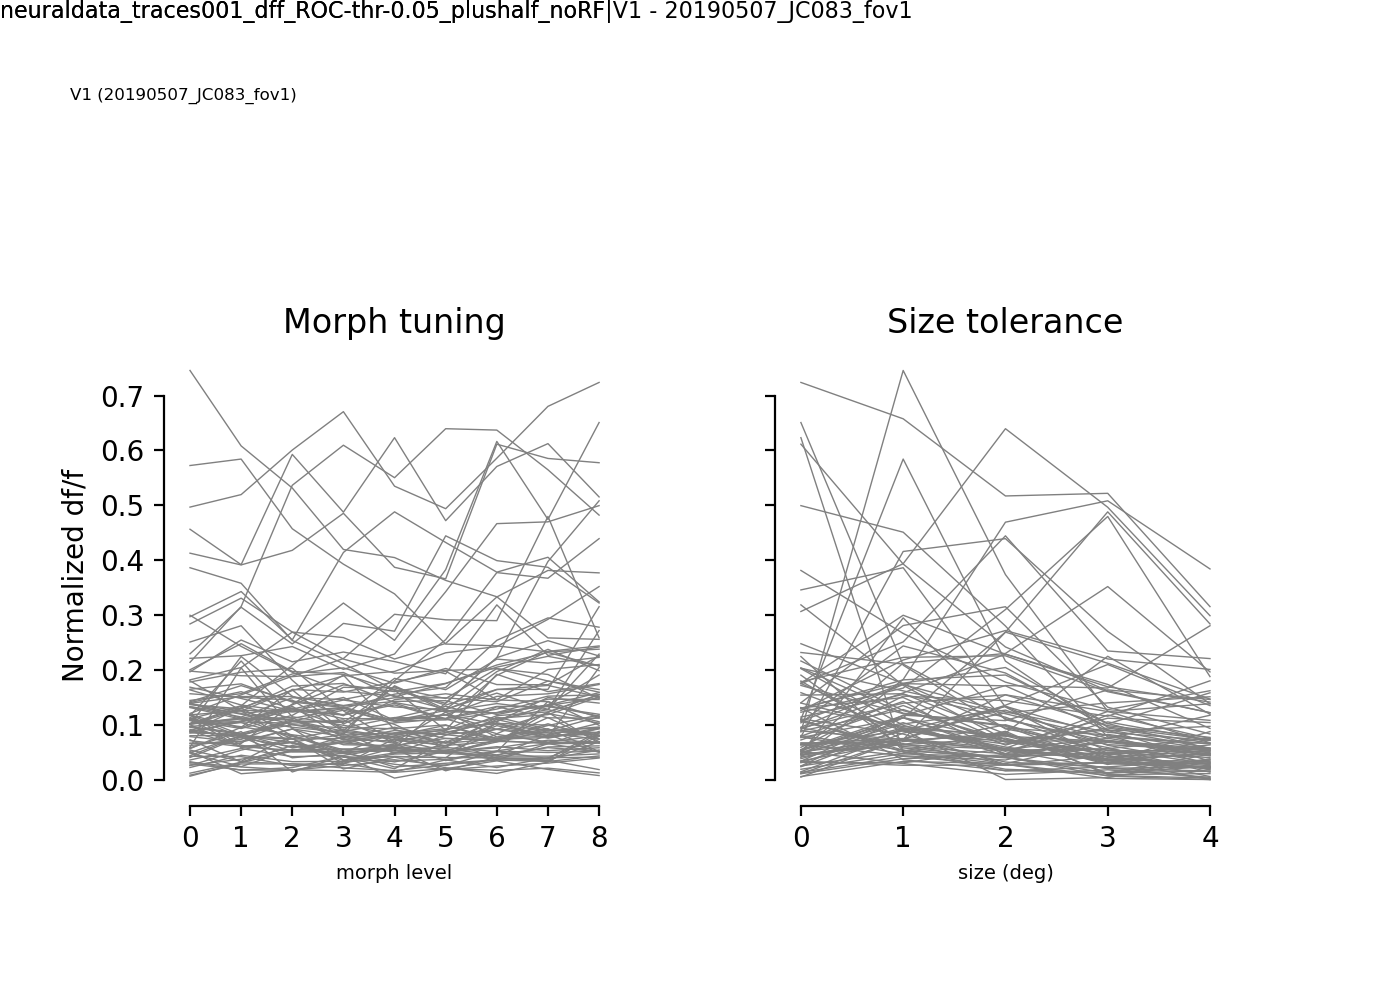

In [32]:
%matplotlib notebook
#### Generate tuning curves
plot_rois=None
roi_styles=None
roi_colors=None
rank_order=False
rank_order_size=False

normalize=False
morph_mat, size_mat = sel.get_object_tuning_curves(rdf[rdf['config'].isin(configs)], 
                                            sort_best_size=rank_order_size,
                                            normalize=normalize, return_stacked=False)
# plot.
fig, axn = pl.subplots(1,2, figsize=(7,5), dpi=100,sharey=True)
fig.patch.set_alpha(1)
ax=axn[0]
rois_mp_labels=None
if plot_rois is not None:
    rois_mp_labels = ['Cell %i, MX=%.2f (best sz=%i)' % \
                     (rid, best_ixs.loc[rid]['morph_sel'], 
                     int(best_ixs.loc[rid]['best_size'])) for rid in plot_rois]
ax = sel.plot_overlaid_tuning_curves(morph_mat, rank_order=False, ax=ax,
                                rois_plot=plot_rois, roi_styles=roi_styles,
                                roi_colors=roi_colors,
                                roi_labels=rois_mp_labels, lw=0.5, lc='gray',
                                roi_lw=2)
xlabel = 'morph level'
ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylabel('Normalized df/f')
ax.set_title("Morph tuning")
# Size Tolerance
ax=axn[1]
roi_sz_labels=None
if plot_rois is not None:
    roi_sz_labels = ['Cell %i, ST=%.2f (best mp=%i)'
                % (rid, best_ixs.loc[rid]['size_tol'], 
                  best_ixs.loc[rid]['best_morphlevel']) for rid in plot_rois]
ax = sel.plot_overlaid_tuning_curves(size_mat, rank_order=rank_order_size, ax=ax,
                                rois_plot=plot_rois, roi_styles=roi_styles,
                                roi_colors=roi_colors,
                                roi_labels=roi_sz_labels, lw=0.5, lc='gray',
                                roi_lw=2)
xlabel = 'Rank-ordered size pref.' if rank_order else 'size (deg)'
ax.set_xlabel(xlabel, fontsize=7)
ax.set_title("Size tolerance")
sns.despine(offset=2, trim=True)

for ax in axn:
    ax.set_box_aspect(1)
fig.text(0.05, 0.9, '%s (%s)' % (va, dk), fontsize=6)
pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)

pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pplot.label_figure(fig, data_id)
# figname = 'aggr_tuning_curves_rid%s__%s_%s' \
#                 % ('_'.join([str(i) for i in sorted(plot_rois)]), va, dk)
#pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))
# print(examples_dir, figname)

In [24]:
configs = sdf[sdf['morphlevel']!=-1].index.tolist()
ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf)
ixs_['visual_area'] = va
ixs_['datakey'] = dk

<IPython.core.display.Javascript object>


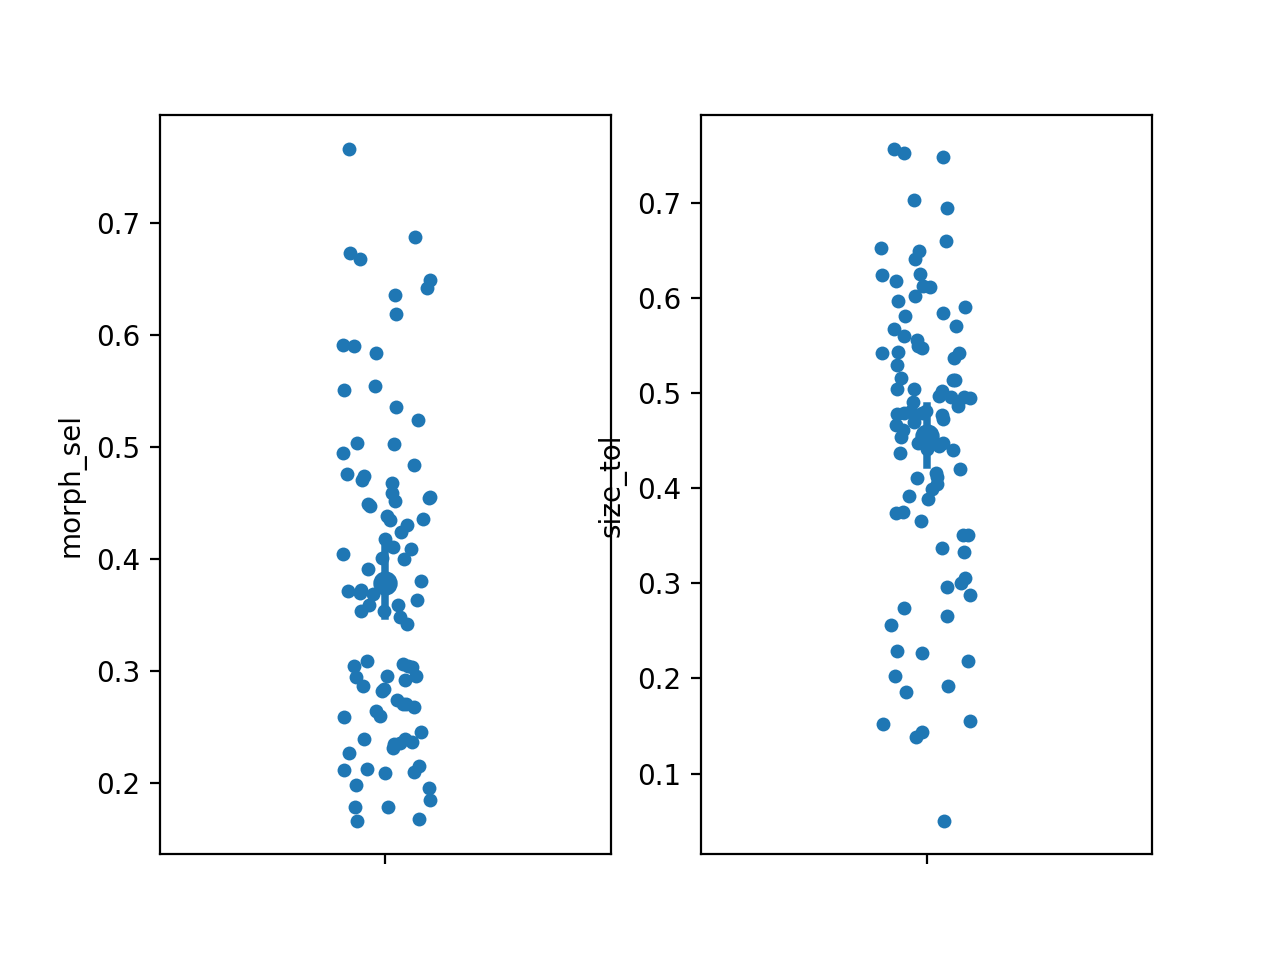

In [29]:
params = ['morph_sel', 'size_tol']

fig, axn = pl.subplots(1, len(params))
for ax, param in zip(axn, params):
    sns.stripplot(data=ixs_, y=param, ax=ax)
    sns.pointplot(data=ixs_, y=param, ax=ax)